This script load the SHAP values computed by Fig5_MM-CNN-SHAP-compute and plot the shap value composites and 

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct
import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pickle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
import importlib
import math
import keras
import random
import importlib
import MM_utilplot
import MM_util_AI
importlib.reload(MM_utilplot)
importlib.reload(MM_util_AI)
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
import matplotlib.colors as colors
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("Reduced_dim_variables"):
            rd_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]   
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]   
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]            
            
print(rd_path)
print(TMindex_path)
print(dim_path)
print(train_path)
print(models_path)
print(fig_path)

latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy')
lon_dict=dict(zip(np.arange(longitudes.size),longitudes))
lat_dict=dict(zip(np.arange(latitudes.size),latitudes))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector
def polorplot(ax,data_xr,max_abs,levels):
    norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    im=xr.plot.contourf( 
        data_xr,
        x="longitude", y="latitude", ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',\
        levels=levels, add_colorbar=False,norm=norm
    )
    gl=ax.gridlines(draw_labels=False)
    gl.ylocator = mticker.FixedLocator([20,40,60,80])  
    gl.xlocator = mticker.FixedLocator([-120,0,120]) 
    ax.coastlines(alpha=0.6)
    
    return ax,im


def polorplot_levels(plotmap,latitudes,longitudes ,minval,maxval, number_levels=30,iv=0.02):
    fig,ax = plt.subplots(figsize=(9,3), 
            subplot_kw={'projection': ccrs.NorthPolarStereo()},ncols=3)
    titles=["Z200","Z500","Z800"]
    max_abs=max(abs(minval),abs(maxval))
    print("min plotmap=", plotmap.min() ,"max plotmap=", plotmap.max() ,)
    ims=[]
    for i in range(3):
        y=plotmap[:,:,i]
        a = xr.DataArray(y, 
            coords={'latitude':latitudes,'longitude': longitudes,}, 
            dims=["latitude","longitude",])
        ax[i],im =polorplot( ax[i],a, max_abs=max_abs,\
                            levels=np.linspace(minval,maxval,number_levels))
        ax[i].set_title(titles[i])
        ims.append(im)
    cbar_ax = fig.add_axes([0.05, -0.1, .9, .05]) #left, bottom, width, height
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal",cmap='coolwarm',\
                        ticks= np.arange(iv*int(minval/iv),iv*int(maxval/iv)+iv,iv),\
                        label = "SHAP values", shrink = 1,)
    print(np.arange(iv*int(minval/iv),iv*int(maxval/iv)+iv,iv))
    fig.tight_layout()
    return fig,ax,ims
refvec = [0, 1]
def compute_boundary(data,threshold,latitudes,longitudes):
    data=data>threshold
    a = xr.DataArray(data, 
        coords={'latitude':latitudes,'longitude': longitudes,}, 
        dims=["latitude","longitude",])
    data=np.argwhere((a==True).values)
    boundary=[]
    for lat in np.unique(data[:,0]):
        sub= np.sort(data[data[:,0]==lat]) 
        boundary.append(sub[0])
        boundary.append(sub[-1])
    for lon in np.unique(data[:,1]):
        sub= np.sort(data[data[:,1]==lon]) 
        boundary.append(sub[0])
        boundary.append(sub[-1])
    boundary=np.unique(boundary,axis=0) 
    boundary_lat_lon=boundary*0.0
    for i in range(boundary.shape[0]):
        boundary_lat_lon[i,0]=lat_dict[boundary[i,0]]
        boundary_lat_lon[i,1]=lon_dict[boundary[i,1]]
    return boundary_lat_lon
def sort_boundary(boundary):
    origin=boundary.mean(axis=0)
    boundary=np.array(sorted(boundary, key=clockwiseangle_and_distance))
    boundary=np.vstack((boundary,boundary[0]))
    return boundary
    
def compute_reg(data,threshold,latitudes,longitudes):
    data=data>threshold
    a = xr.DataArray(data, 
        coords={'latitude':latitudes,'longitude': longitudes,}, 
        dims=["latitude","longitude",])
    data=np.argwhere((a==True).values)
    data_lat_lon=data*0.0
    for i in range(data.shape[0]):
        data_lat_lon[i,0]=lat_dict[data[i,0]]
        data_lat_lon[i,1]=lon_dict[data[i,1]]
    return data_lat_lon

def make_square_reg(boundary,latitudes,longitudes,west_input=None, east_input=None, north_input=None, south_input=None,):
    west=np.min(boundary[:,1])
    east=np.max(boundary[:,1])
    north=np.max(boundary[:,0])
    south=np.min(boundary[:,0])
    if west_input is not None:
        west=west_input
    if east_input is not None:
        east=east_input
    if north_input is not None:
        north=north_input
    if south_input is not None:
        south=south_input
    west=longitudes[np.where(longitudes==west)[0]-1]
    east=longitudes[np.where(longitudes==east)[0]+1]
    north=latitudes[np.where(latitudes==north)[0]+1]
    south=latitudes[np.where(latitudes==south)[0]-1]
    
    lat_span=np.logical_and(latitudes<=north, latitudes>=south)
    lon_span=np.logical_and(longitudes<=east, longitudes>=west)
    lat_span=latitudes[lat_span]
    lon_span=longitudes[lon_span]
    reg=np.meshgrid(lat_span, lon_span)
    reg=np.stack((reg[0].reshape(-1,),reg[1].reshape(-1,))).T
    bdry_index=((reg[:,0]==north)|(reg[:,0]==south)|(reg[:,1]==west)|(reg[:,1]==east)) 
    boundary=reg[bdry_index]
    reg=reg[~bdry_index]
    return reg,boundary

/scratch/hz1994/blocking/data_MMmodel/reduceddim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


# Analyze the shap value data

In [3]:
random_seed=35
epoch=4
path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_%d/"%epoch
pd1_ind=np.load(path+"shap_epoch_%d_seed_%d_TPind.npy"%(epoch,random_seed))
pd2_ind=np.load(path+"shap_epoch_%d_seed_%d_TFind.npy"%(epoch,random_seed))
shap_values_list=np.load(path+"shap_values_list_epoch_%d_seed_%d.npy"%(epoch,random_seed)) 

pd1=shap_values_list[pd1_ind].mean(axis=0)
pd2=shap_values_list[pd2_ind].mean(axis=0)
color=["#000000", "#0072B2", "#009E73", "#D50000","#CC79A7"] 

In [3]:
recompute=False
if recompute:
    boundary=compute_boundary((pd1[1][0])[:,:,0],0.034,latitudes,longitudes).astype(float)
    
    boundary1= boundary[boundary[:,0]<30] 
    origin=boundary1.mean(axis=0)
    boundary1= sort_boundary(boundary1)
    
    boundary2= boundary[boundary[:,1]>-60]
    boundary2= boundary2[boundary2[:,0]<45]
    origin=boundary2.mean(axis=0)
    boundary2= sort_boundary(boundary2)
    
    boundary3= boundary[boundary[:,1]<-60]
    boundary3= boundary3[boundary3[:,0]>30]
    origin=boundary3.mean(axis=0)
    boundary3= sort_boundary(boundary3)
    
    boundary=compute_boundary((pd1[1][0])[:,:,0],0.026,latitudes,longitudes).astype(float)
    boundary4= boundary[boundary[:,0]>50]
    origin=boundary4.mean(axis=0)
    boundary4=sort_boundary(boundary4)
    
    reg= compute_reg ((pd1[1][0])[:,:,0],0.034,latitudes,longitudes) 
    reg1= reg[reg[:,0]<30] 
    
    reg2= reg[reg[:,1]>-60]
    reg2= reg2[reg2[:,0]<45]
    
    reg3= reg[reg[:,1]<-60]
    reg3= reg3[reg3[:,0]>30]
    
    reg= compute_reg ((pd1[1][0])[:,:,0],0.026,latitudes,longitudes) 
    reg4= reg[reg[:,0]>50]
    
    reg1_sq,boundary1_sq=make_square_reg(boundary1,latitudes,longitudes)    
    reg2_sq,boundary2_sq=make_square_reg(boundary2,latitudes,longitudes)  
    reg3_sq,boundary3_sq=make_square_reg(boundary3,latitudes,longitudes)  
    reg4_sq,boundary4_sq=make_square_reg(boundary4,latitudes,longitudes)
    
    origin=boundary1_sq.mean(axis=0)
    boundary1_sq=sort_boundary(boundary1_sq)
    origin=boundary2_sq.mean(axis=0)
    boundary2_sq=sort_boundary(boundary2_sq)
    origin=boundary3_sq.mean(axis=0)
    boundary3_sq=sort_boundary(boundary3_sq)
    origin=boundary4_sq.mean(axis=0)
    boundary4_sq=sort_boundary(boundary4_sq)
    # np.save(path+"reg1",reg1  )
    # np.save(path+"reg2",reg2  )
    # np.save(path+"reg3",reg3  )
    # np.save(path+"reg4",reg4  )
    # np.save(path+"boundary1",boundary1  )
    # np.save(path+"boundary2",boundary2  )
    # np.save(path+"boundary3",boundary3  )
    # np.save(path+"boundary4",boundary4  )
    
    print("Region and boundary information saved at: ",path)
    
    np.save(path+"reg1_sq",reg1_sq  )
    np.save(path+"reg2_sq",reg2_sq )
    np.save(path+"reg3_sq",reg3_sq  )
    np.save(path+"reg4_sq",reg4_sq  )
    np.save(path+"boundary1_sq",boundary1_sq  )
    np.save(path+"boundary2_sq",boundary2_sq  )
    np.save(path+"boundary3_sq",boundary3_sq  )
    np.save(path+"boundary4_sq",boundary4_sq  )

Region and boundary information saved at:  /scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_4/


# True positive data

min plotmap= -0.005317006781655735 max plotmap= 0.04971513352838687
[-0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


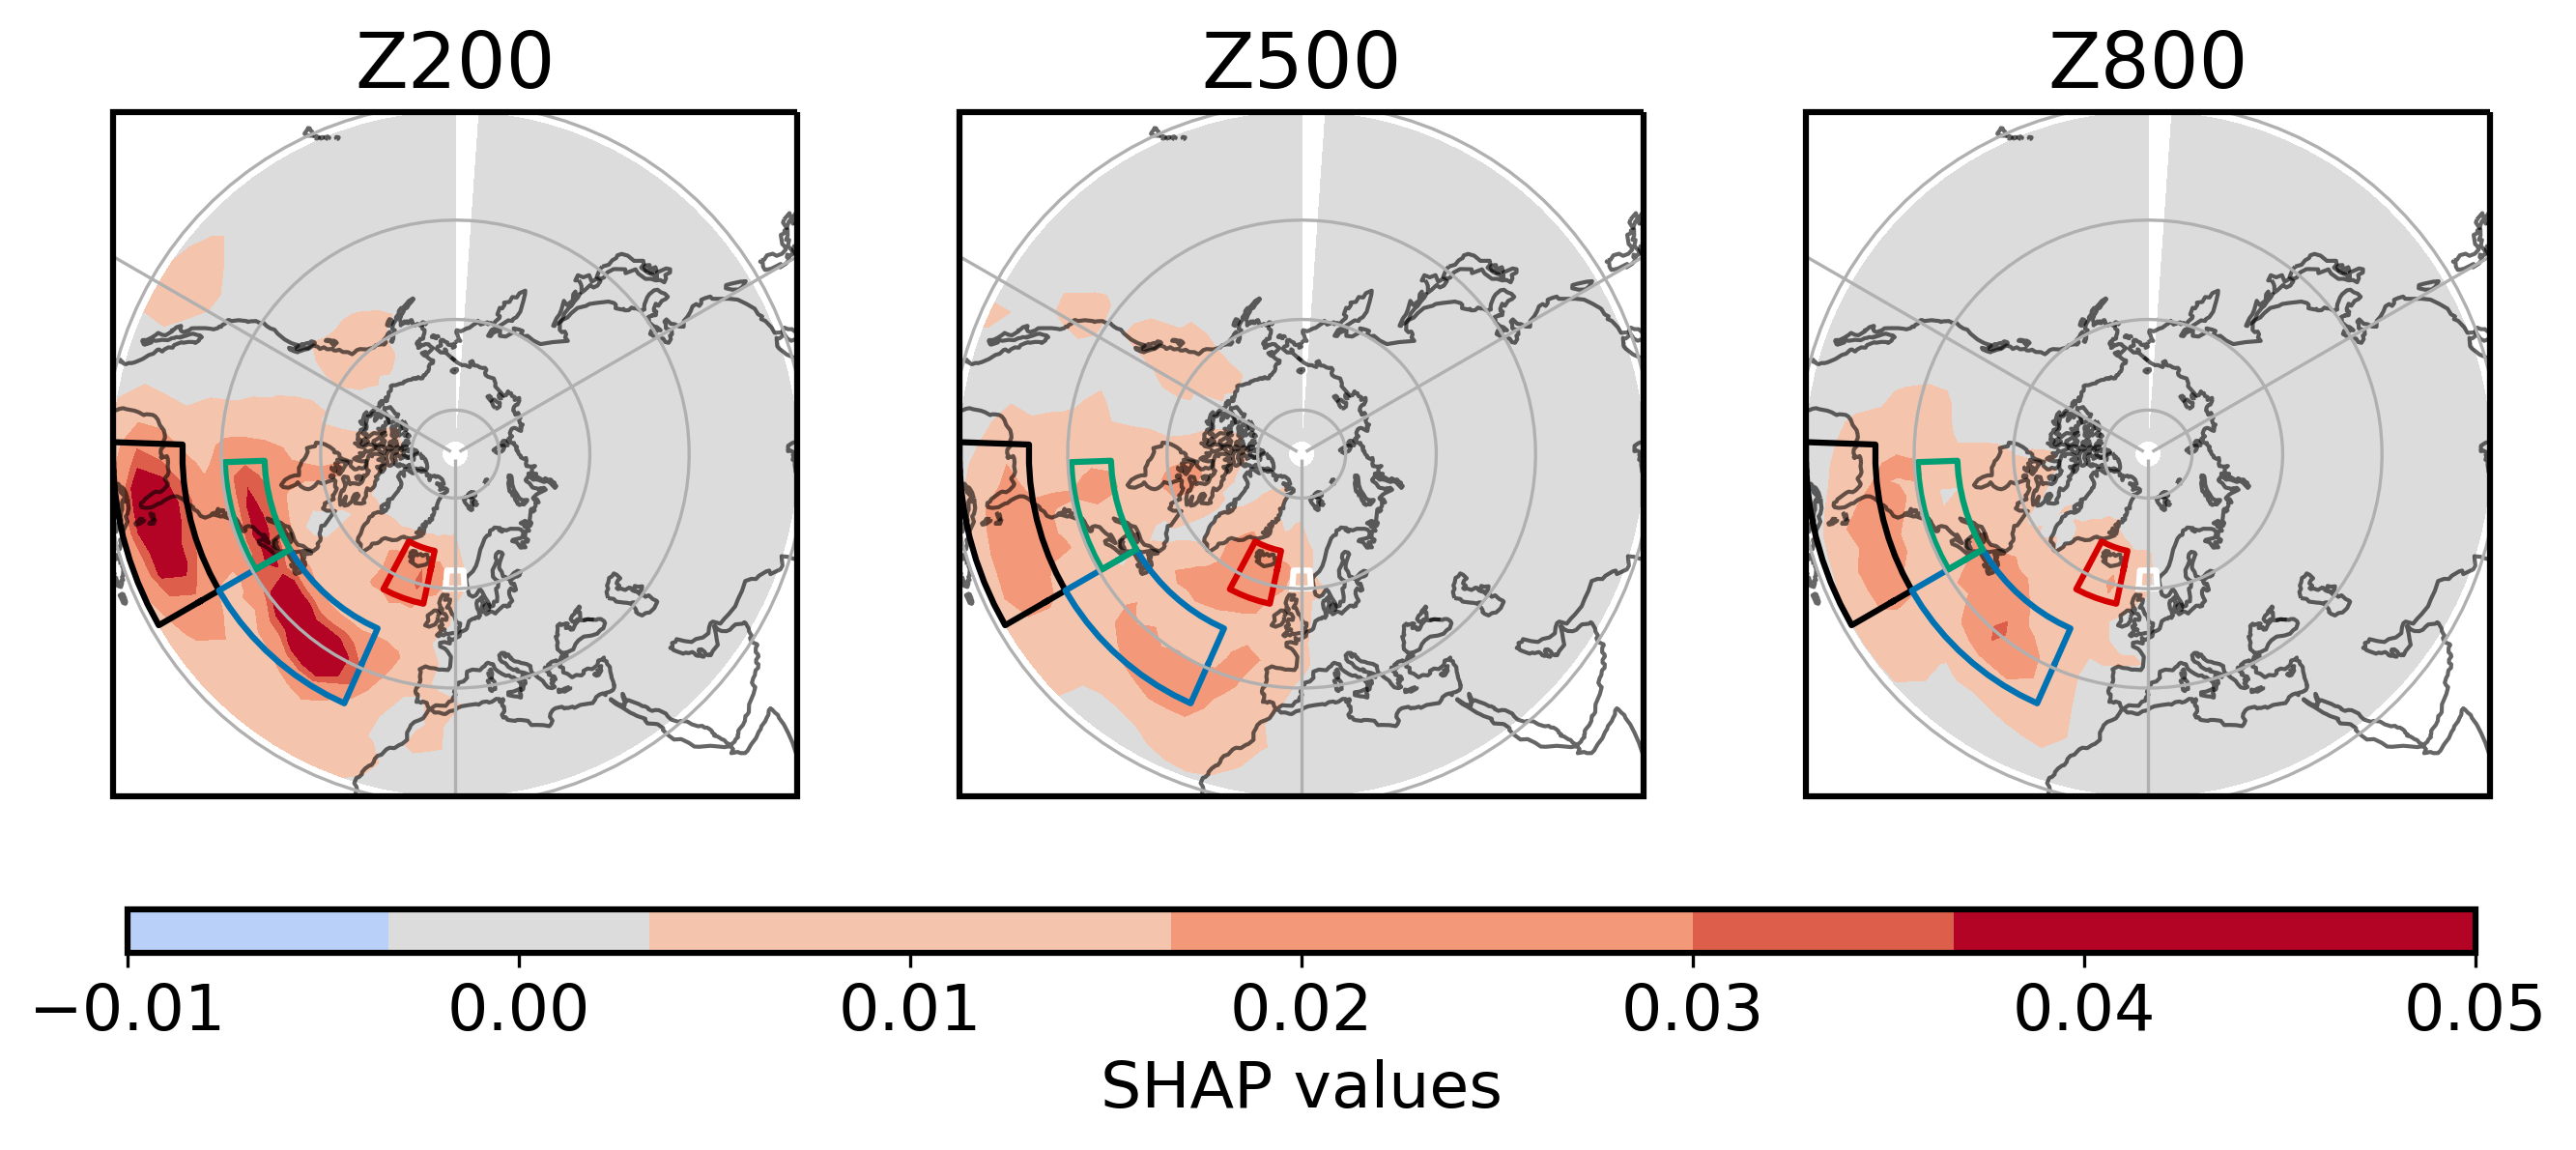

In [18]:
fig,axes,im=polorplot_levels(pd1[1][0],latitudes,longitudes,minval=-0.01,maxval=0.05,number_levels=10,iv=0.01)
boundary1_sq=np.load(path+"boundary1_sq.npy")
boundary2_sq=np.load(path+"boundary2_sq.npy")
boundary3_sq=np.load(path+"boundary3_sq.npy")
boundary4_sq=np.load(path+"boundary4_sq.npy")

for ax in axes:
    ax .plot(boundary1_sq[:,1],boundary1_sq[:,0],'-',color=color[0],alpha = 1,transform=ccrs.PlateCarree(),)
    ax .plot(boundary2_sq[:,1],boundary2_sq[:,0],'-',color=color[1],alpha = 1,transform=ccrs.PlateCarree(),)
    ax .plot(boundary3_sq[:,1],boundary3_sq[:,0],'-',color=color[2],alpha = 1,transform=ccrs.PlateCarree(),)
    ax .plot(boundary4_sq[:,1],boundary4_sq[:,0],'-',color=color[3],alpha = 1,transform=ccrs.PlateCarree(),)

lon_atl=[]
lat_atl=[]
lat_atl=[latitudes[10],latitudes[10],latitudes[11],latitudes[11],latitudes[10]]
lon_atl=[longitudes[44],longitudes[46],longitudes[46],longitudes[44],longitudes[44]]

ax=axes.flatten()
for a in ax:
    a.plot(lon_atl, lat_atl,'w',linestyle='-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')

fig.savefig("Fig6_SHAP_values_sq.png",dpi=300, bbox_inches = "tight")


# True Negative data

min plotmap= -0.02407183029069336 max plotmap= 0.0025219495396746096
[-3.0000000e-02 -2.0000000e-02 -1.0000000e-02  6.9388939e-18
  1.0000000e-02  2.0000000e-02  3.0000000e-02  4.0000000e-02]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


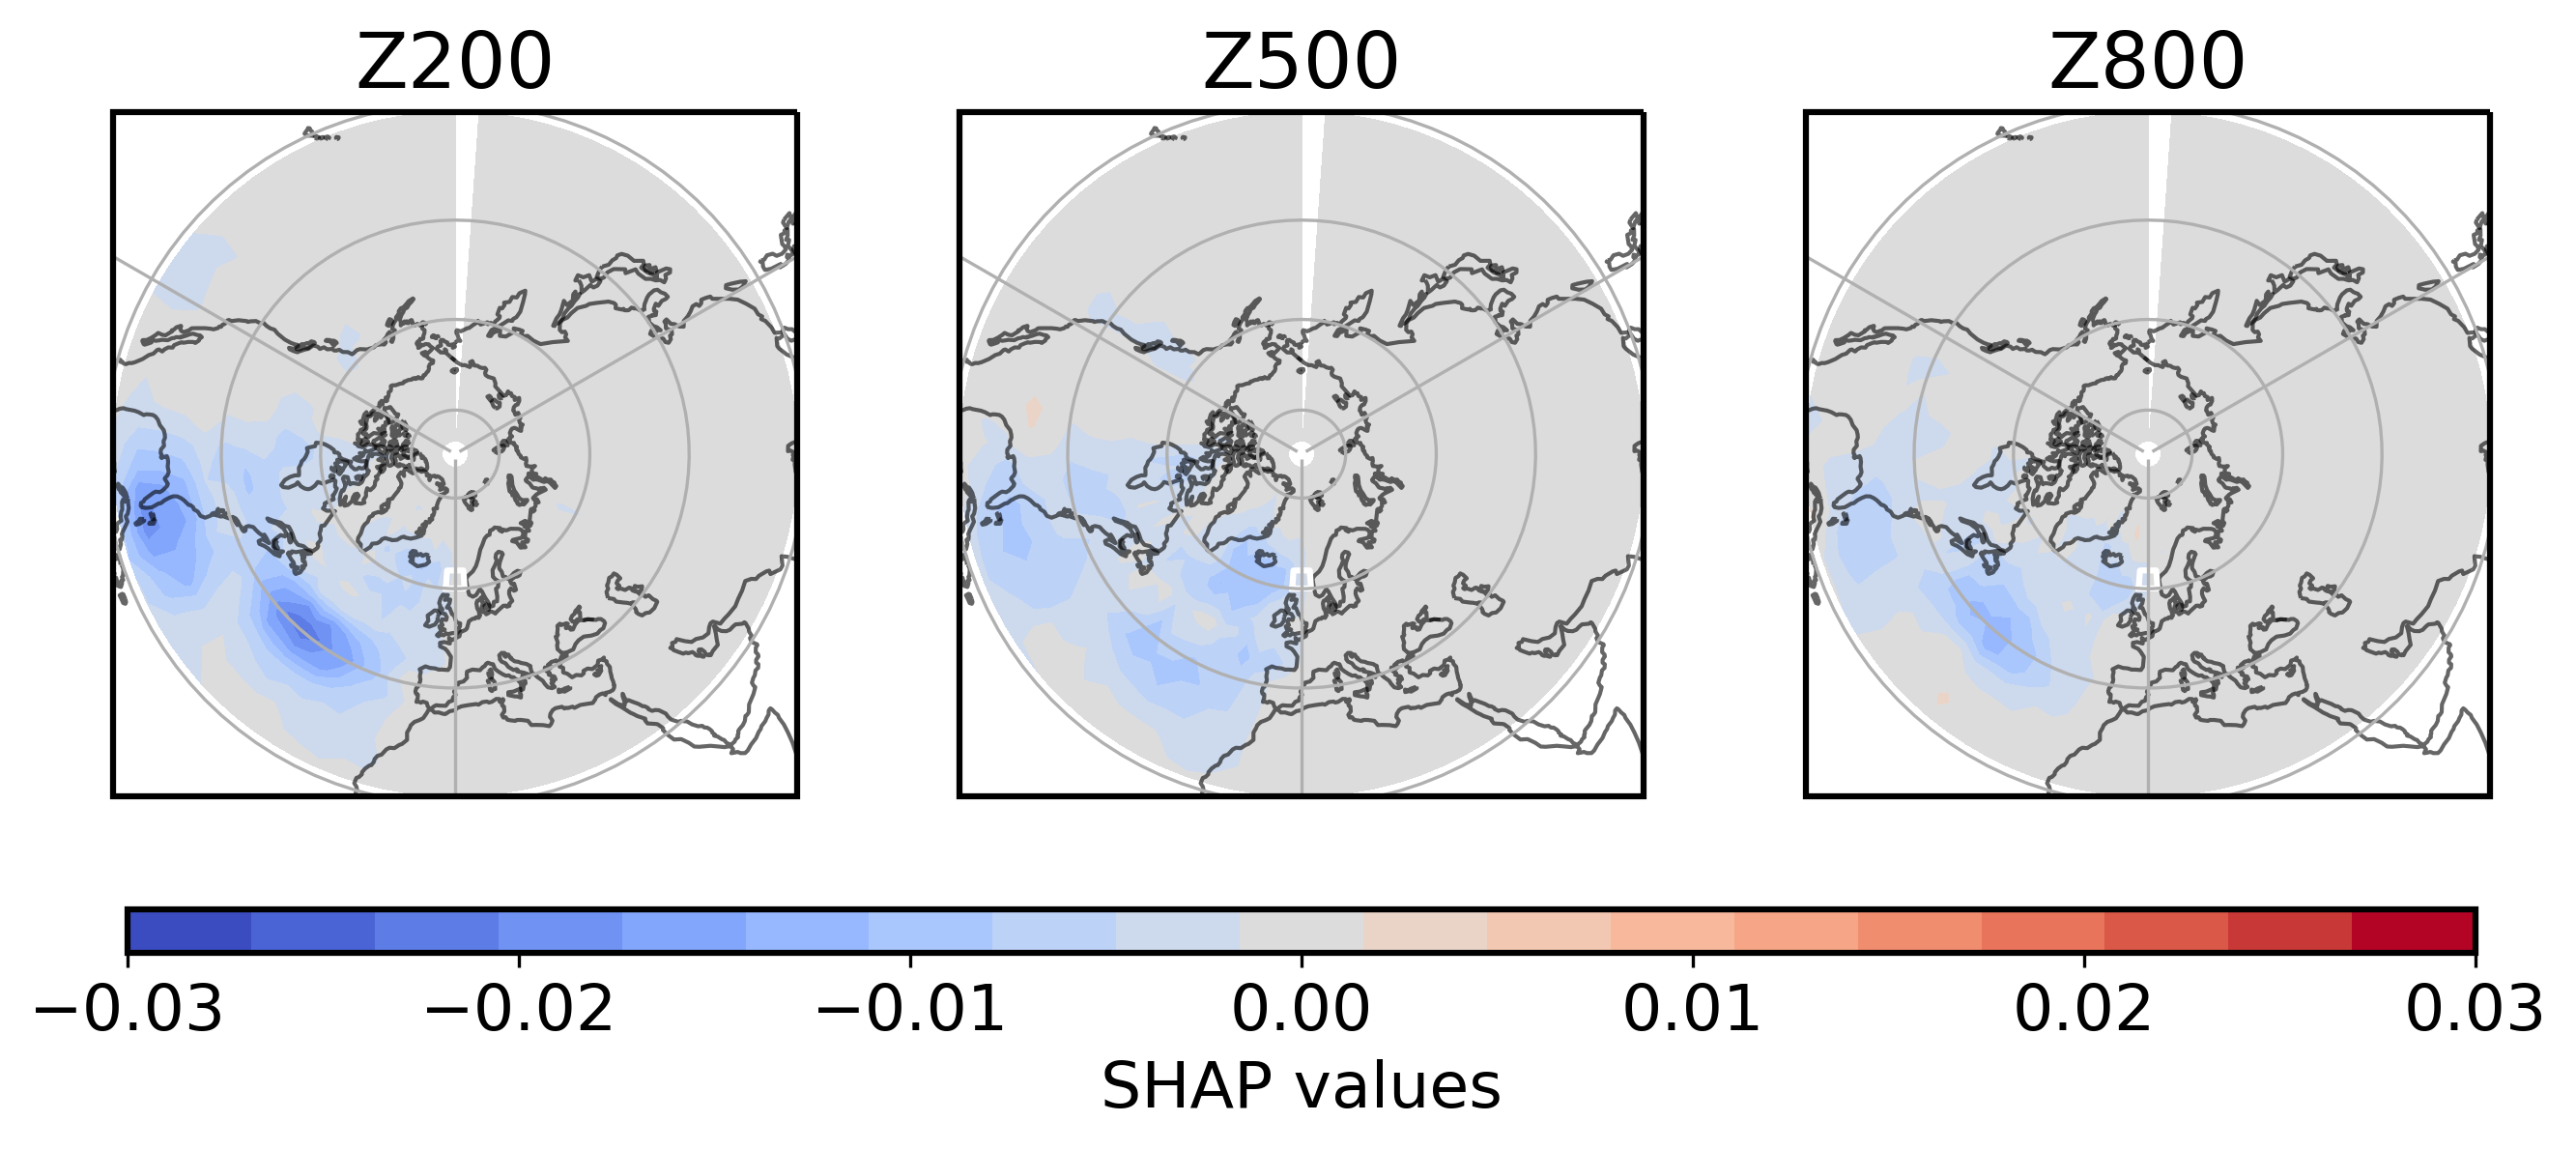

In [11]:
fig,axes,im=polorplot_levels(pd2[1][0],latitudes,longitudes,minval=-0.03,maxval=0.03,number_levels=20,iv=0.01)

lon_atl=[]
lat_atl=[]
lat_atl=[latitudes[10],latitudes[10],latitudes[11],latitudes[11],latitudes[10]]
lon_atl=[longitudes[44],longitudes[46],longitudes[46],longitudes[44],longitudes[44]]

ax=axes.flatten()
for a in ax:
    a.plot(lon_atl, lat_atl,'w',linestyle='-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
